In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import math
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D

In [97]:
df=pd.read_csv("AirPassengers.csv")
 
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [98]:
df.dropna(inplace=True)
df.set_index('Month',inplace=True)
df.index=pd.to_datetime(df.index)

<AxesSubplot:xlabel='Month'>

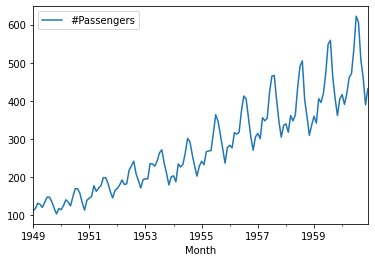

In [99]:
df.plot()

In [100]:
#Convert pandas dataframe to numpy array
data = df.values.astype('float32') 

In [101]:
# Data normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

In [102]:
#Split data as in ARIMA
#Split data into train and test
# Note not as in traditional ML, we cannt pick randomly
size = int(len(data) * 0.75)
train, test = data[0:size], data[size:len(data)]

In [103]:
## Most important step
# prepare time series data for LSTM? (Data windowing)
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        return np.array(dataX), np.array(dataY)

In [104]:
# reshape into X=t and Y=t+1
look_back = 7  # Number of time steps to look back 

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [112]:
print("Training X shape: {}".format(trainX.shape))
print("Training y shape: {}".format(trainY.shape))
print("Test X shape: {}".format(testX.shape))
print("Test y shape: {}".format(testY.shape))

Training X shape: (100, 7, 1)
Training y shape: (100,)
Test X shape: (28, 7, 1)
Test y shape: (28,)


Next is the shape of the input; that is what the model expects as input for each sample in terms of the number of time steps and the number of features.

- We are working with a univariate series, so the number of `features` is one, for one variable.

- The number of `time_steps` as input is the number we chose when preparing our dataset as an argument to the create_dataset() function `time_steps`=`look_back`

The shape of the input for each sample is specified in the input_shape argument on the definition of first hidden layer.
The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: `[samples, time steps, features]`.

Currently, our data is in the form: `[samples, time_steps]` and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:

In [113]:
# Reshape input to be [samples, timesteps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1 )) # 1 is the number of features
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1 ))
print("Training set shape: {}".format(trainX.shape))
print("Test set shape: {}".format(testX.shape))


Training set shape: (100, 7, 1)
Test set shape: (28, 7, 1)


##### Single LSTM with hidden Dense-


In [114]:
# create the LSTM network
model = Sequential()
# input_shape=(n_steps, n_features))
model.add(LSTM(10, input_shape=(7,1)))
model.add(Dense(5))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()



Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 6         
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


In [119]:
# fit the LSTM network
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Epoch 1/100
100/100 - 1s - loss: 0.0069
Epoch 2/100
100/100 - 0s - loss: 0.0064
Epoch 3/100
100/100 - 0s - loss: 0.0069
Epoch 4/100
100/100 - 0s - loss: 0.0061
Epoch 5/100
100/100 - 0s - loss: 0.0062
Epoch 6/100
100/100 - 0s - loss: 0.0058
Epoch 7/100
100/100 - 0s - loss: 0.0055
Epoch 8/100
100/100 - 0s - loss: 0.0057
Epoch 9/100
100/100 - 0s - loss: 0.0062
Epoch 10/100
100/100 - 0s - loss: 0.0056
Epoch 11/100
100/100 - 0s - loss: 0.0054
Epoch 12/100
100/100 - 0s - loss: 0.0058
Epoch 13/100
100/100 - 0s - loss: 0.0051
Epoch 14/100
100/100 - 0s - loss: 0.0051
Epoch 15/100
100/100 - 0s - loss: 0.0050
Epoch 16/100
100/100 - 0s - loss: 0.0049
Epoch 17/100
100/100 - 0s - loss: 0.0046
Epoch 18/100
100/100 - 0s - loss: 0.0043
Epoch 19/100
100/100 - 0s - loss: 0.0042
Epoch 20/100
100/100 - 0s - loss: 0.0042
Epoch 21/100
100/100 - 0s - loss: 0.0040
Epoch 22/100
100/100 - 0s - loss: 0.0041
Epoch 23/100
100/100 - 0s - loss: 0.0035
Epoch 24/100
100/100 - 0s - loss: 0.0038
Epoch 25/100
100/100 - 0s

In [120]:
# make predictions

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [121]:
trainPredict[0]
# we need to denormalize

array([0.07912566], dtype=float32)

###### invert predictions back to prescaled values using `scaler.inverse_transform()`

In [122]:
#This is to compare with original input values
#SInce we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.
trainPredict = scaler.inverse_transform(trainPredict)
trainYY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testYY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainYY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testYY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 23.21 RMSE
Test Score: 50.94 RMSE


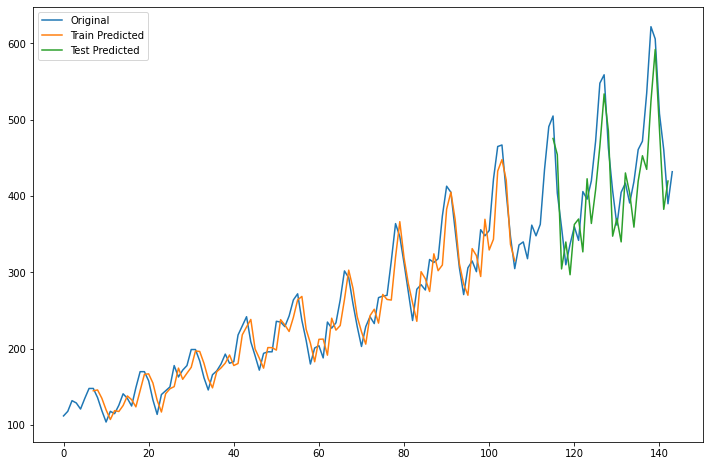

In [123]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(dataset),label="Original")
plt.plot(trainPredictPlot,label="Train Predicted")
plt.plot(testPredictPlot,label="Test Predicted")
plt.legend()
plt.show()
